# Churn prediction project

Logistic regression: g(xi)=SIGMOID(w0+wTxi) → outputs a number 0..1∈R
sigmoid(z)= 1 / (1+exp(−z))


# Data preparation


In [ ]:
url = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/refs/heads/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv"
#!curl -o churn.csv $url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  954k  100  954k    0     0   764k      0  0:00:01  0:00:01 --:--:--  768k


In [ ]:
import pandas
import numpy

# import sklearn

In [135]:
df = pandas.read_csv("../../data/raw/churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [136]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [137]:
# read all columns with their data (transpose col to row)
df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


In [138]:
df.columns = df.columns.str.lower()
cols = df.dtypes[df.dtypes == "object"].index
df.head()

for col in cols:
    df[col] = df[col].str.lower().str.replace(" ", "_")

df.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-vhveg,female,0,yes,no,1,no,no_phone_service,dsl,no,...,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,no
1,5575-gnvde,male,0,no,no,34,yes,no,dsl,yes,...,yes,no,no,no,one_year,no,mailed_check,56.95,1889.5,no
2,3668-qpybk,male,0,no,no,2,yes,no,dsl,yes,...,no,no,no,no,month-to-month,yes,mailed_check,53.85,108.15,yes
3,7795-cfocw,male,0,no,no,45,no,no_phone_service,dsl,yes,...,yes,yes,no,no,one_year,no,bank_transfer_(automatic),42.30,1840.75,no
4,9237-hqitu,female,0,no,no,2,yes,no,fiber_optic,no,...,no,no,no,no,month-to-month,yes,electronic_check,70.70,151.65,yes


In [139]:
df.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges         object
churn                object
dtype: object

In [140]:
# change the object feild to num and fix the col err value
print(df.totalcharges[df.totalcharges == "_"])

df.totalcharges = pandas.to_numeric(df.totalcharges, errors="coerce")

print(df.totalcharges.iloc[488])
df.totalcharges = df.totalcharges.fillna(0)

df.totalcharges[df.totalcharges == 0]

488     _
753     _
936     _
1082    _
1340    _
3331    _
3826    _
4380    _
5218    _
6670    _
6754    _
Name: totalcharges, dtype: object
nan


488     0.0
753     0.0
936     0.0
1082    0.0
1340    0.0
3331    0.0
3826    0.0
4380    0.0
5218    0.0
6670    0.0
6754    0.0
Name: totalcharges, dtype: float64

In [141]:
print(df.churn.head())

df.churn = df.churn == "yes"
df.churn = df.churn.astype(int)

df.churn.head()

0     no
1     no
2    yes
3     no
4    yes
Name: churn, dtype: object


0    0
1    0
2    1
3    0
4    1
Name: churn, dtype: int64

# Setting Up The Validation Framework

perform the train/validation/test split with scikit-learn


In [142]:
from sklearn.model_selection import train_test_split

In [ ]:

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
len(df_full_train), len(df_test)

(5634, 1409)

In [ ]:
# 80/20 = 1/4 = 0.25
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_test), len(df_val)

(4225, 1409, 1409)

In [145]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [146]:
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

In [147]:
del df_train["churn"]
del df_val["churn"]
del df_test["churn"]

In [149]:
df_train.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,8015-ihcgw,female,0,yes,yes,72,yes,yes,fiber_optic,yes,yes,yes,yes,yes,yes,two_year,yes,electronic_check,115.50,8425.15
1,1960-uycnn,male,0,no,no,10,yes,yes,fiber_optic,no,yes,yes,no,no,yes,month-to-month,yes,electronic_check,95.25,1021.55
2,9250-wypll,female,0,no,no,5,yes,yes,fiber_optic,no,no,no,no,no,no,month-to-month,no,electronic_check,75.55,413.65
3,6786-obwqr,female,0,yes,yes,5,yes,no,fiber_optic,no,no,no,no,yes,no,month-to-month,yes,electronic_check,80.85,356.10
4,1328-euzhc,female,0,yes,no,18,yes,no,no,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,20.10,370.50


# EDA (Exploratory data analysis)

Checking missing values
Looking at the distribution of the target variable (churn)
Looking at numerical and categorical variables


In [150]:
df_full_train.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [155]:
print(df_full_train.churn.value_counts())
# the % of churn data than unchurn
df_full_train.churn.value_counts(normalize=True)

churn
0    4113
1    1521
Name: count, dtype: int64


churn
0    0.730032
1    0.269968
Name: proportion, dtype: float64

In [ ]:
global_churn_rate = df_full_train.churn.mean()
round(global_churn_rate, 2)

np.float64(0.27)

In [ ]:
# check the category var
print("*df_full_train.dtypes:\n", df_full_train.dtypes)

numerical = ["tenure", "monthlycharges", "totalcharges"]

print("*df_full_train.columns:\n", df_full_train.columns)
categorical = [
    "gender",
    "seniorcitizen",
    "partner",
    "dependents",
    "phoneservice",
    "multiplelines",
    "internetservice",
    "onlinesecurity",
    "onlinebackup",
    "deviceprotection",
    "techsupport",
    "streamingtv",
    "streamingmovies",
    "contract",
    "paperlessbilling",
    "paymentmethod",
]

*df_full_train.dtypes:
 customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges        float64
churn                 int64
dtype: object
*df_full_train.columns:
 Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 

In [172]:
df_full_train[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

# Churn Rate

(the difference and the risk ratio as two important tools for assessing feature importance)
global - group
negative result <0 : the group is more likely to churn
positive result >0 : the group is less likely to churn


In [ ]:
# find which feature affect more the churn

churn_female = df_full_train[df_full_train.gender == "female"].churn.mean()
print(churn_female)
churn_male = df_full_train[df_full_train.gender == "male"].churn.mean()
print(churn_male)

print("")
# no affect of this feature
print(global_churn_rate - churn_female)
print(global_churn_rate - churn_male)

0.27682403433476394
0.2632135306553911

-0.006855983216553063
0.006754520462819769


In [ ]:
print(df_full_train.partner.value_counts())
print("")

churn_partner = df_full_train[df_full_train.partner == "yes"].churn.mean()
print(churn_partner)
churn_no_partner = df_full_train[df_full_train.partner == "no"].churn.mean()
print(churn_no_partner)

print("")

print(global_churn_rate - churn_partner)
# the result is negative (most likely the churn)
print(global_churn_rate - churn_no_partner)

partner
no     2932
yes    2702
Name: count, dtype: int64

0.20503330866025166
0.3298090040927694

0.06493474245795922
-0.05984095297455855


# Risk Ratio

(measure the important of features)
the group has result >1 is more likely to churn
the group has result <1 is less likely to churn


In [191]:
print(churn_partner / global_churn_rate)
print(churn_no_partner / global_churn_rate)

0.7594724924338315
1.2216593879412643


Let’s take the data and group it by gender, and for each variable within the gender group, let’s calculate the average churn rate within that group and calculate the difference and risk. We can perform this analysis for all the variables, not just the gender variable.

The SQL query would look like:

SELECT
gender,
AVG(churn),
AVG(churn) - global_churn AS diff,
AVG(churn) / global_churn AS risk
FROM
date
GROUP BY
gender;


df.groupby('x').y.agg([mean()]) - returns a dataframe with mean of y series grouped by x series


In [ ]:
from IPython.display import display

for c in categorical:
    df_group = df_full_train.groupby(c).churn.agg(["mean", "count"])
    df_group["diff"] = df_group["mean"] - global_churn_rate
    df_group["risk"] = df_group["mean"] / global_churn_rate
    display(df_group)
    print()

,mean,count,diff,risk
gender,,,,
female,0.276824,2796,0.006856,1.025396
male,0.263214,2838,-0.006755,0.974980


,mean,count,diff,risk
seniorcitizen,,,,
0,0.242270,4722,-0.027698,0.897403
1,0.413377,912,0.143409,1.531208


,mean,count,diff,risk
partner,,,,
no,0.329809,2932,0.059841,1.221659
yes,0.205033,2702,-0.064935,0.759472


,mean,count,diff,risk
dependents,,,,
no,0.313760,3968,0.043792,1.162212
yes,0.165666,1666,-0.104302,0.613651


,mean,count,diff,risk
phoneservice,,,,
no,0.241316,547,-0.028652,0.893870
yes,0.273049,5087,0.003081,1.011412


,mean,count,diff,risk
multiplelines,,,,
no,0.257407,2700,-0.012561,0.953474
no_phone_service,0.241316,547,-0.028652,0.893870
yes,0.290742,2387,0.020773,1.076948


,mean,count,diff,risk
internetservice,,,,
dsl,0.192347,1934,-0.077621,0.712482
fiber_optic,0.425171,2479,0.155203,1.574895
no,0.077805,1221,-0.192163,0.288201


,mean,count,diff,risk
onlinesecurity,,,,
no,0.420921,2801,0.150953,1.559152
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.153226,1612,-0.116742,0.567570


,mean,count,diff,risk
onlinebackup,,,,
no,0.404323,2498,0.134355,1.497672
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.217232,1915,-0.052736,0.804660


,mean,count,diff,risk
deviceprotection,,,,
no,0.395875,2473,0.125907,1.466379
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.230412,1940,-0.039556,0.853480


,mean,count,diff,risk
techsupport,,,,
no,0.418914,2781,0.148946,1.551717
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.159926,1632,-0.110042,0.592390


,mean,count,diff,risk
streamingtv,,,,
no,0.342832,2246,0.072864,1.269897
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.302723,2167,0.032755,1.121328


,mean,count,diff,risk
streamingmovies,,,,
no,0.338906,2213,0.068938,1.255358
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.307273,2200,0.037305,1.138182


,mean,count,diff,risk
contract,,,,
month-to-month,0.431701,3104,0.161733,1.599082
one_year,0.120573,1186,-0.149395,0.446621
two_year,0.028274,1344,-0.241694,0.104730


,mean,count,diff,risk
paperlessbilling,,,,
no,0.172071,2313,-0.097897,0.637375
yes,0.338151,3321,0.068183,1.252560


,mean,count,diff,risk
paymentmethod,,,,
bank_transfer_(automatic),0.168171,1219,-0.101797,0.622928
credit_card_(automatic),0.164339,1217,-0.105630,0.608733
electronic_check,0.455890,1893,0.185922,1.688682
mailed_check,0.193870,1305,-0.076098,0.718121


# Feature importance: Mutual information

(how much do we learn about churn if we have the information from a particular feature. So, it is a measure of the importance of a categorical variable)


In [ ]:
from sklearn.metrics import mutual_info_score

print(mutual_info_score(df_full_train.churn, df_full_train.contract))
print("contract", mutual_info_score(df_full_train.contract, df_full_train.churn))

# we learn nothing about churn if we know the gender
print("gender", mutual_info_score(df_full_train.churn, df_full_train.gender))

print("partner", mutual_info_score(df_full_train.churn, df_full_train.partner))

0.0983203874041556
contract 0.0983203874041556
gender 0.0001174846211139946
partner 0.009967689095399745


In [ ]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_full_train.churn)


mi = df_full_train[categorical].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

contract            0.098320
onlinesecurity      0.063085
techsupport         0.061032
internetservice     0.055868
onlinebackup        0.046923
deviceprotection    0.043453
paymentmethod       0.043210
streamingtv         0.031853
streamingmovies     0.031581
paperlessbilling    0.017589
dependents          0.012346
partner             0.009968
seniorcitizen       0.009410
multiplelines       0.000857
phoneservice        0.000229
gender              0.000117
dtype: float64

# Feature importance: Correlation

(Correlation coefficient: measures the degree of dependency between two variables. This value is negative if one variable grows while the other decreases, and it is positive if both variables increase. Depending on its size, the dependency between both variables could be low, moderate, or strong. It allows measuring the importance of numerical variables)


In [ ]:
# returns the correlation between x and y series. This is a function from pandas.
df_full_train[numerical].corrwith(df_full_train.churn)
# when increase the tenure lead to decrease the churn
# when increase the monthlycharges lead to increase the churn

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64

In [ ]:
# 2 months
print(df_full_train[df_full_train.tenure <= 2].churn.mean())

print(df_full_train[df_full_train.tenure > 2].churn.mean())

print(
    df_full_train[
        (df_full_train.tenure > 2) & (df_full_train.tenure <= 12)
    ].churn.mean()
)

print(df_full_train[df_full_train.tenure > 12].churn.mean())

0.5953420669577875
0.22478269658378816
0.3994413407821229
0.17634908339788277


In [210]:
# what the mean of churn when values of feature is <cond>
print(df_full_train[df_full_train.monthlycharges <= 20].churn.mean())

print(
    df_full_train[
        (df_full_train.monthlycharges > 20) & (df_full_train.monthlycharges <= 50)
    ].churn.mean()
)

print(df_full_train[df_full_train.monthlycharges > 50].churn.mean())

0.08795411089866156
0.18340943683409436
0.32499341585462205


# One-Hot Encoding

(encode categorical features to binary)


In [ ]:
# create new feilds of one column depends on the nunique (not numeric) value have ,then fill it will 0,1
# if the value of col is num ,will leave it like it is
from sklearn.feature_extraction import DictVectorizer

# ex.
# print(df_train[["gender", "contract"]].iloc[:50])
# train_dicts = df_train[["gender", "contract"]].iloc[:50].to_dict(orient="records")
# train_dicts

In [ ]:
# print(df_train[categorical + numerical])
train_dicts = df_train[categorical + numerical].to_dict(orient="records")
train_dicts

dv = DictVectorizer(sparse=False)

# init dv and transform the features
X_train = dv.fit_transform(train_dicts)
print(dv.feature_names_)
print(X_train.shape)
print(X_train[0])

# val transform
val_dicts = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dicts)

['contract=month-to-month', 'contract=one_year', 'contract=two_year', 'dependents=no', 'dependents=yes', 'deviceprotection=no', 'deviceprotection=no_internet_service', 'deviceprotection=yes', 'gender=female', 'gender=male', 'internetservice=dsl', 'internetservice=fiber_optic', 'internetservice=no', 'monthlycharges', 'multiplelines=no', 'multiplelines=no_phone_service', 'multiplelines=yes', 'onlinebackup=no', 'onlinebackup=no_internet_service', 'onlinebackup=yes', 'onlinesecurity=no', 'onlinesecurity=no_internet_service', 'onlinesecurity=yes', 'paperlessbilling=no', 'paperlessbilling=yes', 'partner=no', 'partner=yes', 'paymentmethod=bank_transfer_(automatic)', 'paymentmethod=credit_card_(automatic)', 'paymentmethod=electronic_check', 'paymentmethod=mailed_check', 'phoneservice=no', 'phoneservice=yes', 'seniorcitizen', 'streamingmovies=no', 'streamingmovies=no_internet_service', 'streamingmovies=yes', 'streamingtv=no', 'streamingtv=no_internet_service', 'streamingtv=yes', 'techsupport=no

# Logistic Regression

(same formula for linear reg but the result is from 0 to 1 , not from -infinty to +infinty)


In [237]:
def sigmoid(z):
    return 1 / (1 + numpy.exp(-z))

In [ ]:
# ex.
z = numpy.linspace(-7, 7, 51)
print(z)
sigmoid(z)

[-7.0000000e+00 -6.7200000e+00 -6.4400000e+00 -6.1600000e+00
 -5.8800000e+00 -5.6000000e+00 -5.3200000e+00 -5.0400000e+00
 -4.7600000e+00 -4.4800000e+00 -4.2000000e+00 -3.9200000e+00
 -3.6400000e+00 -3.3600000e+00 -3.0800000e+00 -2.8000000e+00
 -2.5200000e+00 -2.2400000e+00 -1.9600000e+00 -1.6800000e+00
 -1.4000000e+00 -1.1200000e+00 -8.4000000e-01 -5.6000000e-01
 -2.8000000e-01  8.8817842e-16  2.8000000e-01  5.6000000e-01
  8.4000000e-01  1.1200000e+00  1.4000000e+00  1.6800000e+00
  1.9600000e+00  2.2400000e+00  2.5200000e+00  2.8000000e+00
  3.0800000e+00  3.3600000e+00  3.6400000e+00  3.9200000e+00
  4.2000000e+00  4.4800000e+00  4.7600000e+00  5.0400000e+00
  5.3200000e+00  5.6000000e+00  5.8800000e+00  6.1600000e+00
  6.4400000e+00  6.7200000e+00  7.0000000e+00]


np.float64(3.7200759760208356e-44)

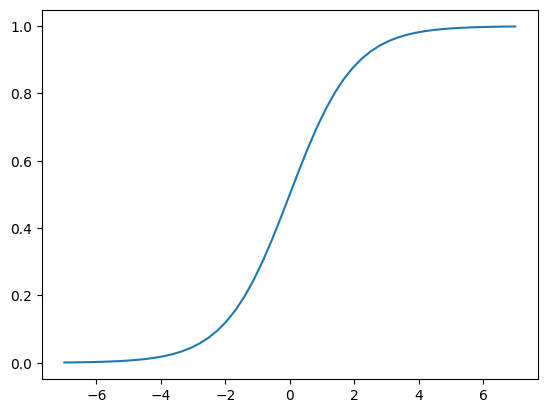

In [245]:
import matplotlib.pyplot as plt

plt.plot(z, sigmoid(z))

In [ ]:
# ex
# def logistic_regression(xi):
#     score = w0

#     for j in range(len(w)):
#         score = score + xi[j] * w[j]

#     result = sigmoid(score)
#     return result

# Training Logistic Regression with Scikit-Learn


In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
# training the logistic regression model
model.fit(X_train, y_train)

/Users/ZenaAbdalkarem/Documents/ML/ML-homeworks/machine-learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [ ]:
# return the bias or intercept of the LR model
model.intercept_[0]

np.float64(-0.10892432327116425)

In [ ]:
# return the coefficients or weights of the LR model
model.coef_[0].round(3)

array([ 0.475, -0.175, -0.408, -0.03 , -0.078,  0.063, -0.089, -0.081,
       -0.034, -0.073, -0.335,  0.317, -0.089,  0.004, -0.258,  0.142,
        0.009,  0.062, -0.089, -0.081,  0.265, -0.089, -0.284, -0.231,
        0.123, -0.166,  0.059, -0.087, -0.032,  0.07 , -0.059,  0.142,
       -0.249,  0.215, -0.12 , -0.089,  0.102, -0.071, -0.089,  0.052,
        0.213, -0.089, -0.232, -0.07 ,  0.   ])

In [ ]:
# make predictions on the x dataset by returning two columns with their probabilities for the two categories - soft predictions
y_pred = model.predict_proba(X_val)[:, 1]
y_pred

array([0.0090183 , 0.20503392, 0.21264696, ..., 0.13664055, 0.79977661,
       0.83738853], shape=(1409,))

In [ ]:
churn_decision = y_pred >= 0.5
# to send the email for these customer ids
df_val[churn_decision].customerid

3       8433-wxgna
8       3440-jpscl
11      2637-fkfsy
12      7228-omtpn
19      6711-fldfb
           ...    
1397    5976-jcjrh
1398    2034-cgrhz
1399    5276-kqwhg
1407    6521-yytyi
1408    3049-solay
Name: customerid, Length: 311, dtype: object

In [255]:
# validating the model
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

# Model interpretation


In [ ]:
# return the bias or intercept of the LR model
model.intercept_[0]

np.float64(-0.10892432327116425)

In [ ]:
# return the coefficients or weights of the LR model
model.coef_[0].round(3)

array([ 0.475, -0.175, -0.408, -0.03 , -0.078,  0.063, -0.089, -0.081,
       -0.034, -0.073, -0.335,  0.317, -0.089,  0.004, -0.258,  0.142,
        0.009,  0.062, -0.089, -0.081,  0.265, -0.089, -0.284, -0.231,
        0.123, -0.166,  0.059, -0.087, -0.032,  0.07 , -0.059,  0.142,
       -0.249,  0.215, -0.12 , -0.089,  0.102, -0.071, -0.089,  0.052,
        0.213, -0.089, -0.232, -0.07 ,  0.   ])